In [20]:
import os
import pandas as pd
import wget
import sys
import subprocess
from subprocess import call
import matplotlib.pyplot as plt
%matplotlib inline

import random
import json

import numpy as np

from metamind.api import ClassificationData, ClassificationModel, set_api_key

sys.path.append(os.environ["HOME"])
from ds_config import *

print os.environ["HOME"]
MAIN_PATH = os.environ["HOME"]+"/GLaDOS_Workspace/"
#os.mkdir(MAIN_PATH)
#os.mkdir(MAIN_PATH+"Videos/")
#os.mkdir(MAIN_PATH+"Images/")

/Users/williamspearman


# FFMPEG Scrips

In [2]:
def getVideoInfo(file_name):
    bashCommand = "ffprobe -show_streams " + file_name
    process = subprocess.Popen(bashCommand.split(" "), stdout=subprocess.PIPE)
    output = process.communicate()[0].split("\n")
    ret_dict = { }
    for x in output:
        if "=" in x:
            key_vals = x.split("=")
            ret_dict[key_vals[0]] = key_vals[1]
    #print ret_dict
    return ret_dict


def getGetSignalBkgTriplets(file_name, snap_time, pm_secs=1.):
    ret_val = { }
    info_dict = getVideoInfo(file_name)
    required_vals = { "duration", "nb_frames", "avg_frame_rate", "sample_aspect_ratio" }
    if len(required_vals.intersection(set(info_dict.keys())))!=len(required_vals):
        return None
    frame_rate = 0.
    try:
        frame_rate = float(info_dict["avg_frame_rate"].split("/")[0])/float(info_dict["avg_frame_rate"].split("/")[1])
    except:
        return None
    num_frames = float(info_dict["nb_frames"])
    duration = float(info_dict["duration"])

    if int(num_frames/frame_rate-duration)!= 0:
        return None
    
    pm_frames = pm_secs * frame_rate
    snap_frame = snap_time * frame_rate
    
    snap_frame_low = snap_frame-pm_frames
    snap_frame_high = snap_frame+pm_frames
    if snap_frame_low<0:
        return None
    if snap_frame_high>num_frames:
        return None
    
    int1 = [ pm_frames, max(0,snap_frame_low-pm_frames) ]
    int2 = [ min(pm_frames+snap_frame_high, num_frames), num_frames-pm_frames ]
    bkg_frame = getRandInt(int1, int2)
    
    ret_val["SNAP"] = [ snap_frame_low/frame_rate, snap_frame/frame_rate, snap_frame_high/frame_rate ]
    ret_val["NOT_SNAP"] = [ (bkg_frame-pm_frames)/frame_rate, bkg_frame/frame_rate, (bkg_frame+pm_frames)/frame_rate ]
    
    return ret_val
    
def downloadUrl(url):
    base_name = ""
    try:
        base_name = url.split("/")[-1]
    except:
        return ""
    
    output_name = MAIN_PATH + "Videos/" + base_name
    if os.path.isfile(output_name)==False:
        wget.download(url, MAIN_PATH+"Videos/")
    
    if os.path.isfile(output_name)==True:
        return output_name
    else:
        return ""



def makeImageMontage(url, snap_time, time_offset=0.5):
    ret_val = [ ]
    video_path = downloadUrl(url)
    #print "BLah %f" % 0.2
    base_name = ""
    try:
        base_name = video_path.split("/")[-1].split(".")[0]
    except:
        print "Failed splitting: %s" % video_path
        return None
    input_times = getGetSignalBkgTriplets(video_path, snap_time, time_offset)
    if input_times==None:
        return ret_val
    #resolution = resolution.replace(":", "x")
    #name1 = "blah"
    #name2 = "blah"
    ffmpeg_cmds = { }
    file_names = { }
    for mykey in input_times.keys():
        output_name = MAIN_PATH + "Images/" + base_name
        ffmpeg_cmds[mykey] = [ ]
        file_names[mykey] = [ ]
        for x, i in zip(input_times[mykey], range(0,len(input_times[mykey]))):
            file_name = "%s_%i_%s.jpg" % (output_name, i, mykey)
            file_names[mykey].append(file_name)
            ffmpeg_cmds[mykey].append("ffmpeg -ss %f -i %s -vframes 1 %s 2> /dev/null" % (x, video_path, file_name))
        #montage_cmd = "montage -tile 1x3 -geometry 512x256+0+0 "
        montage_cmd = "montage -tile 1x3 -geometry 512x+0+0 "
        for thecmd, fname in zip(ffmpeg_cmds[mykey], file_names[mykey]):
            call(thecmd, shell=True)
            montage_cmd = montage_cmd+fname+" "
        montage_name = "%s_%i_%s_MONTAGE.jpg" % (output_name, int(1000*input_times[mykey][1]), mykey)
        montage_cmd = montage_cmd + " " + montage_name
        call(montage_cmd,shell=True)
        for fname in file_names[mykey]:
            os.remove(fname)
        ret_val.append((montage_name, mykey))
        
        
        
            
    return ret_val


def getSnapImage(url, snap_time, formation):
    #ret_val = [ ]
    video_path = downloadUrl(url)
    if video_path=="":
        return ( "", formation )
    #print "BLah %f" % 0.2
    base_name = ""
    try:
        base_name = video_path.split("/")[-1].split(".")[0]
    except:
        print "Failed splitting: %s" % video_path
        return ( "", formation )
    output_name = MAIN_PATH + "Images/" + base_name

    file_name = "%s_%s.jpg" % (output_name, formation)
    ffmpeg_cmd = "ffmpeg -ss %f -i %s -vframes 1 %s 2> /dev/null" % (snap_time, video_path, file_name)
    call(ffmpeg_cmd, shell=True)
    os.remove(video_path)
            
    return ( file_name, formation )


In [5]:
print getSnapImage("http://vf.hudl.com/9n6/81k/bab387d7-c875-4df6-89f7-3a0c910deb6a/lelyp36kuaykgm1j-3000_1100.mp4",\
                       8.809,  "TRIPS")

('/Users/williamspearman/GLaDOS_Workspace/Images/lelyp36kuaykgm1j-3000_1100_TRIPS.jpg', 'TRIPS')


In [3]:
formationRDD = sc.textFile("s3n://hudl-hadoop/GLaDOS/formation_data/").map(json.loads)


In [13]:
formationRDD.take(1)

[{u'formation': u'TRIPS',
  u'off form': u'TRIPS',
  u'play type': u'Run',
  u'video': {u'snap confidence': 1,
   u'snap time': 3.804,
   u'urls': [u'http://vi.hudl.com/ynt/bmm/6db9a53a-0f69-41fc-8ed3-6d905d5c9240/hexwejs1qxsweu5j-1100.mp4']}}]

In [4]:
def changeName(x):
    if x["formation"]=="I FORMATION":
        x["formation"] = "I_FORMATION"
    return x

finalRDD = formationRDD\
    .map(changeName)\
    .map(lambda x: ( x["video"]["urls"][-1], x["formation"], x["video"]["snap time"] ))
    
tripsRDD = finalRDD.filter(lambda x: x[1]=="TRIPS").cache()
iformationRDD = finalRDD.filter(lambda x: x[1]=="I_FORMATION").cache()
emptyRDD = finalRDD.filter(lambda x: x[1]=="EMPTY").cache()

trips_size = tripsRDD.count()
i_size = iformationRDD.count()
empty_size = emptyRDD.count()
print "Trips: %i" % trips_size
print "Empty: %i" % empty_size
print "I Formation: %i" % i_size
num_wanted=50.

tripsRDD_small = tripsRDD.sample(False, num_wanted/trips_size)
iformationRDD_small = iformationRDD.sample(False, num_wanted/i_size)
emptyRDD_small = emptyRDD.sample(False, num_wanted/empty_size)

finalRDD = tripsRDD_small\
    .union(iformationRDD_small)\
    #.union(emptyRDD_small)


Trips: 4869
Empty: 990
I Formation: 1129


In [5]:
print "Trips: %i" % tripsRDD_small.count()
print "Empty: %i" % emptyRDD_small.count()
print "I Formation: %i" % iformationRDD_small.count()

Trips: 38
Empty: 56
I Formation: 38


In [30]:
test_inputRDD = finalRDD\
    .map(lambda x: getSnapImage(x[0],x[2],x[1]))\
    .cache()
    #.filter(lambda x: x != "")\
    
training_inputs = test_inputRDD.collect()   
#

In [7]:
empty_arr = emptyRDD.collect()
for x in empty_arr:
    print getSnapImage(x[0],x[2],x[1])

(u'/Users/williamspearman/GLaDOS_Workspace/Images/011-t9gt_EMPTY.jpg', u'EMPTY')
(u'/Users/williamspearman/GLaDOS_Workspace/Images/631sbv0pomlrcazo-3000_1100_EMPTY.jpg', u'EMPTY')
(u'/Users/williamspearman/GLaDOS_Workspace/Images/054-axbj_1100_EMPTY.jpg', u'EMPTY')
(u'/Users/williamspearman/GLaDOS_Workspace/Images/dbnmipiqspmnmzki-1100_EMPTY.jpg', u'EMPTY')
(u'/Users/williamspearman/GLaDOS_Workspace/Images/jeczymbsdtrw4t8t-3000_1100_EMPTY.jpg', u'EMPTY')
(u'/Users/williamspearman/GLaDOS_Workspace/Images/cencfrikgpavghiq-3000_1100_EMPTY.jpg', u'EMPTY')
(u'/Users/williamspearman/GLaDOS_Workspace/Images/ah7df2rwpbppivcf-3000_1100_EMPTY.jpg', u'EMPTY')
(u'/Users/williamspearman/GLaDOS_Workspace/Images/mlvfogbaeosmt9oc_1100_EMPTY.jpg', u'EMPTY')
(u'/Users/williamspearman/GLaDOS_Workspace/Images/drwiz9phbizlfbyb_1100_EMPTY.jpg', u'EMPTY')
(u'/Users/williamspearman/GLaDOS_Workspace/Images/hn8w5i1thsfe1big_1100_EMPTY.jpg', u'EMPTY')
(u'/Users/williamspearman/GLaDOS_Workspace/Images/gtzmp6szq3g

In [6]:
iformation_arr = iformationRDD.collect()
for x in iformation_arr:
    print getSnapImage(x[0],x[2],x[1])

(u'/Users/williamspearman/GLaDOS_Workspace/Images/f66ajoryukyg5yw6-1100_I_FORMATION.jpg', 'I_FORMATION')
(u'/Users/williamspearman/GLaDOS_Workspace/Images/qy7rzvxeir2pfjuj-3000_1100_I_FORMATION.jpg', 'I_FORMATION')
(u'/Users/williamspearman/GLaDOS_Workspace/Images/008-4pzb_I_FORMATION.jpg', 'I_FORMATION')
(u'/Users/williamspearman/GLaDOS_Workspace/Images/043-itoy_I_FORMATION.jpg', 'I_FORMATION')
(u'/Users/williamspearman/GLaDOS_Workspace/Images/009-oxso_1100_I_FORMATION.jpg', 'I_FORMATION')
(u'/Users/williamspearman/GLaDOS_Workspace/Images/ugeog05dzprsp2du-3000_1100_I_FORMATION.jpg', 'I_FORMATION')
(u'/Users/williamspearman/GLaDOS_Workspace/Images/bbalyclkluc5ocjb_1100_I_FORMATION.jpg', 'I_FORMATION')
(u'/Users/williamspearman/GLaDOS_Workspace/Images/wagq4ozhj3wcvr6x-1100_I_FORMATION.jpg', 'I_FORMATION')
(u'/Users/williamspearman/GLaDOS_Workspace/Images/ewd0g0yiul4vyhpg-1100_I_FORMATION.jpg', 'I_FORMATION')
(u'/Users/williamspearman/GLaDOS_Workspace/Images/sqtiqi6qdhpo4r7r-1100_I_FORMA

In [9]:
def getInputs(path, formation):
    ret_val = [ ]
    for myfile in os.listdir(path):
        if formation in myfile:
            ret_val.append( ( os.path.join(path,myfile), formation) )
    return ret_val

In [22]:
iformation = getInputs("/Users/williamspearman/GLaDOS_Workspace/Images","I_FORMATION")
trips = getInputs("/Users/williamspearman/GLaDOS_Workspace/Images","TRIPS")
empty = getInputs("/Users/williamspearman/GLaDOS_Workspace/Images","EMPTY")

min_len = min(len(iformation),min(len(trips),len(empty)))
input_data = iformation[:min_len]+empty[:min_len]
random.shuffle(input_data)

In [23]:
input_data[:3]

[('/Users/williamspearman/GLaDOS_Workspace/Images/kz6bufpfvolwnbx4-1100_I_FORMATION.jpg',
  'I_FORMATION'),
 ('/Users/williamspearman/GLaDOS_Workspace/Images/i3piofqpid3ljjeu_1100_EMPTY.jpg',
  'EMPTY'),
 ('/Users/williamspearman/GLaDOS_Workspace/Images/bgj2n08nobtjsdf2-1100_I_FORMATION.jpg',
  'I_FORMATION')]

In [24]:
set_api_key(metamind_api_key)

Hello, William Spearman


In [25]:
training_data = ClassificationData(private=True, data_type="image", name="iformation_empty")




You are creating dataset 'iformation_empty', with id: 152263


In [26]:
training_data.add_samples(input_data, input_type="files")


Starting data upload...
Finished uploading 150 of 1598 samples...
Finished uploading 300 of 1598 samples...
Finished uploading 450 of 1598 samples...
Finished uploading 600 of 1598 samples...
Finished uploading 750 of 1598 samples...
Finished uploading 900 of 1598 samples...
Finished uploading 1050 of 1598 samples...
Finished uploading 1200 of 1598 samples...
Finished uploading 1350 of 1598 samples...
Finished uploading 1500 of 1598 samples...
Finished uploading 1598 of 1598 samples...


In [27]:
classifier = ClassificationModel(private=True, name="iformation_empty")
classifier.fit_async(training_data)



Your MetaMind image model is now training on the server!


In [43]:
classifier.status()

u'running'

2.88399658203


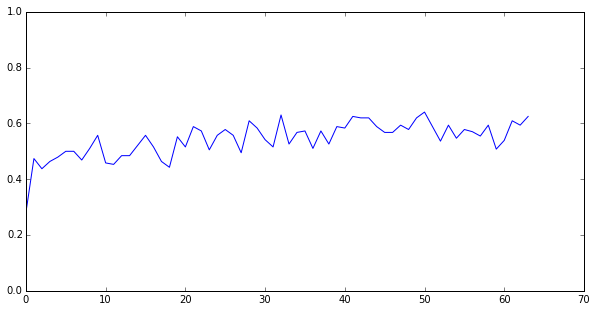

In [47]:
plt.figure(figsize=(10, 5))
print classifier.stats()["time_left"] / 60.
#print clf02.stats()["time_left"] / 60.
#print clf03.stats()["time_left"] / 60.

plt.plot(classifier.stats()["training_stats"]["train_accuracy"])
#plt.plot(clf02.stats()["training_stats"]["train_accuracy"])
#plt.plot(clf03.stats()["training_stats"]["train_accuracy"])
plt.ylim([0, 1])
plt.show() 

In [88]:
preds = classifier.predict(fg_test_set, input_type="files")

/home/ubuntu/anaconda/lib/python2.7/site-packages/requests/packages/urllib3/util/ssl_.py:79: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. For more information, see https://urllib3.readthedocs.org/en/latest/security.html#insecureplatformwarning.
  InsecurePlatformWarning
/home/ubuntu/anaconda/lib/python2.7/site-packages/requests/packages/urllib3/util/ssl_.py:79: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. For more information, see https://urllib3.readthedocs.org/en/latest/security.html#insecureplatformwarning.
  InsecurePlatformWarning
Traceback (most recent call last):
  File "/home/ubuntu/anaconda/lib/python2.7/site-packages/metamind/api/utils.py", line 34, in make_request
    return validate_result(response)
  File "/home/ubuntu/anac

In [94]:
preds = pd.DataFrame([
    classifier.predict(fg, input_type="files") for fg in fg_test_set
])

/home/ubuntu/anaconda/lib/python2.7/site-packages/requests/packages/urllib3/util/ssl_.py:79: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. For more information, see https://urllib3.readthedocs.org/en/latest/security.html#insecureplatformwarning.
  InsecurePlatformWarning
/home/ubuntu/anaconda/lib/python2.7/site-packages/requests/packages/urllib3/util/ssl_.py:79: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. For more information, see https://urllib3.readthedocs.org/en/latest/security.html#insecureplatformwarning.
  InsecurePlatformWarning
/home/ubuntu/anaconda/lib/python2.7/site-packages/requests/packages/urllib3/util/ssl_.py:79: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL 

In [102]:
pred_dicts = []

for d in preds.values:
    pred_dicts.append(d[0])

In [103]:
preds = pd.DataFrame(pred_dicts)

In [112]:
preds.groupby("label").label.count()

label
fg       153
punt      25
Name: label, dtype: int64